<a href="https://colab.research.google.com/github/aa25desh/graph/blob/master/wright_fisher_hints_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an ipython notebook. Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

I recommend installing the [Anaconda](https://store.continuum.io/cshop/academicanaconda) distribution. Make sure not to pay for it! Click Anaconda Academic License; it should be free for those with academic e-mail addresses.

Open the notebook by (1) copying this file into a directory, (2) in that directory typing 
ipython notebook
and (3) selecting the notebook.




In this exercise, we will build a Wright-Fisher simulation model, which will be the basis of most of our simulation efforts. 



# Wright-Fisher model
## Motivation



Population genetics seeks to describe and understand patterns of genetic diversity found in natural and artificial populations. Blood groups, which are genetically determined, have very uneven geographical distributions:
![Distribution of B blood groups](https://www2.palomar.edu/anthro/vary/images/map_of_B_blood_in_the_world.gif)

We can ask many questions about these distributions: Are these the result of natural selection? Of dramatic historical events? Or are they simply meaningless random distributions? To understand the data, we need to build models for the data that make predictions and can be falsified.             

In this exercise, we will build a simple model for the evolution of allele frequencies in a population. We will use this model over and over in this course. To build an evolutionary model, we need to specify a number of parameters: the population size, the structure of the genome (e.g., the number of chromosomes, its ploidy), the mode of reproduction of the population (e.g., sexual vs asexual), whether individuals have mate choice preferences, the distribution in the number and timing of offspring by individual, how mutations arise, how alleles are transmitted from parent to offspring. We also have to decide on the starting point in our model, the ancestral population from which we will consider evolution. This represents a lot of choices. Our first model will try to keep everything as simple as possible:



* Population size:    constant, $N$

* Structure of the genome:   one single haploid chromosome of length 1 base pair. 

* Mode of reproduction:      asexual

* Mutation process:          No mutation

* Transmission:              Asexual transmission (clonal reproduction)

* Distribution of offspring: ?

It was straightforrward to come up with the simplest parameters so far, but here we need to think a bit more. Since we have a haploid population of constant size, the average number of offspring per individual must be one. If every individual has exactly one offspring, the population will never change, and the model will fail to account for the observed variation in reproductive success across individuals.  
 
If we let each parent independently spawn a random number of offspring, the population size could change a little bit at every generation. That's not a problem per se, since real populations sizes do fluctuate over time. However, it is often useful to treat the population as a known parameter. This is the case, for example, if we want to predict genomic diversity in a population of known size. 

If parents vary in their number of offspring, how can they synchronize to produce exactly one offspring, on average?
One way would be to add feedback, reducing the mean number of offspring when the population size increases, and increasing it when the population size decreases. That could work, but there are many parameters to fix, and even there we can't control the population size all that well.    


There are a few elegant but slightly strange ways of solving this problem by keeping the population size at an exact, predefined $N$. First, we'll imagine that reproduction is synchronized across all individuals in the population. 
Then, we'll suppose that each parent produces very many offspring, but that only $N$ offspring from the entire population are allowed to survive, and these are selected at random among all offspring. You can also turn the table and imagine that each of the allowed $N$ offspring "picks" a parent at random. If you don't like the idea of an offspring choosing its parents, you can imagine a higher power selecting a parent at random to generate every offspring. 

These approaches are equivalent, in that they make the same predictions about the number of surviving offsprings per parent. **Take the time to convince yourself that this is the case.**

This sampling approach defines the Wright-Fisher model. We can add many features to this model, such as selection, recombination, mutation, and so forth, but as long as you have this discrete generations and random selection of parents, you're within the Wright-Fisher model.       

I'll just mention one alternative, called the Moran Model, which involves replacing a single, randomly selected individual by the genotype of another, randomly selected individual, and repeating this $N$ times per generation. The Moran model is not exactly equivalent to the Wright-Fisher model, and there are cases where it is more convenient. But we'll stick to Wright-Fisher for this notebook.    

*Optional Mathematical exercise*

1. What is the distribution of offspring number per individual in the Wright-Fisher model? 

2. Convince yourself that this distribution is approximately Poisson distributed with mean one (hint: This is a consequence of the law of rare events) 

## Libraries
We'll need the following python plotting libraries. 

In [0]:
### 1
%matplotlib inline 
# If you run into errors with %matplotlib, check that your version of ipython is >=1.0 
import numpy as np # Numpy defines useful functions for manipulating arrays and matrices.
import matplotlib.pyplot as plt # Matplotlib is a plotting library

## Implementation

We have specified almost everything we needed in the model, except for the initial state of the population. We will suppose that the single site has two alleles labeled $0$ and $1$. We need to specify the number of individuals nInd in the initial population and the proportion $p_0$ of $1$ alleles


In [0]:
### 2
p0   = 0.1  # initial proportion of "1" alleles 
nInd = 100  # initial population size (number of individuals)


Now we need to create an initial population with the given number of individuals, and the appropriate proportion of 1 alleles. We'll store the population as a np.array called "initial_population", of length nInd containing 0s and 1s.

In [0]:
### 3
# Initialize a population of length nInd with only 0 alleles. 
initial_population = np.concatenate( ([1]*int(p0*nInd), [0]*int(nInd*(1-p0))), axis =0 )
np.random.shuffle(initial_population)

# Set the first p0*nInd alleles to 1. 

# Now all the 1 alleles are at the beginning of the array, with the remainder filled with zero.
# The position of individuals doesn't matter in this model, but if you prefer to have a more realistically random 
# distribution of alleles, you can use np.random.shuffle to distribute alleles randomly.

To take finite samples from this population, we can use the np.random.choice function. When taking a sample from a population, we can pick each sample only once--the "replace=False" option below tells us that we don't replace the sampled individual in the population before drawing a new one. Read the np.random.choice documentation for more detail! 

In [0]:
### 4
sample_size = 10
np.random.choice(initial_population, sample_size, replace=False )

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

When we take repeated samples from the same population, we can find different numbers of alternate alleles: There are random fluctuations not only in the reproduction, but also in the experimental sampling. We'll first have a look at all these distributions.

*Optional Mathematical exercise*
    
    1-What is the distribution of the number of alternate alleles in a sample of $s$ individuals from a population of size $nInd$ with  allele frequency p?


I generated a bunch of samples below, and compared the resulting histogram to plausible probability distributions so that you can pick the one that fits best. If you don't do the math problems, read the wikipedia entry about the best-fitting one and check that it makes sense. 

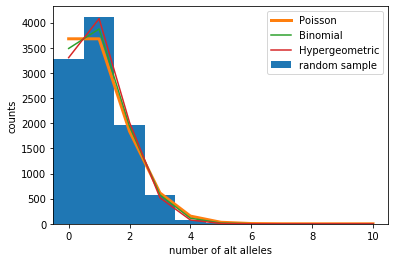

In [0]:
### 5
import scipy
from scipy import stats

iterations = 10000  # the number of times to draw.
sample_size = 10  # the size of each sample
alt_counts = []  # number of alternate alleles (i.e., 1's) for each draw

for i in range(iterations):
    sample = np.random.choice(initial_population, sample_size, replace=False)
    # Get the number of alt alleles
    alt_counts.append(sample.sum())
    
# Plot a histogram of sampled values    
plt.hist(alt_counts, sample_size + 1, range=(-0.5, sample_size + 1 - 0.5), label="random sample")
plt.xlabel("number of alt alleles")
plt.ylabel("counts")

# Compare this to some discrete distributions
x_range = range(sample_size + 1) # All the possible values

p = np.sum(initial_population) * 1. / len(initial_population)  # Initial fraction of alt's

# Poisson with mean sample_size * p
y_poisson = stats.poisson.pmf(x_range, sample_size*p) * iterations
# Binomial with probability p and  sample_size draws
y_binom = stats.binom.pmf(x_range, sample_size,p) * iterations
# Hypergeometric draw of sample_size from population of size len(initial_populationpop)
# with np.sum(initial_population) ones.
y_hypergeom = stats.hypergeom.pmf(x_range, len(initial_population), np.sum(initial_population), sample_size)\
                * iterations

plt.plot(x_range, y_poisson, label="Poisson", lw=3)
plt.plot(x_range, y_binom, label="Binomial")
plt.plot(x_range, y_hypergeom, label="Hypergeometric")
plt.xlim(-0.5, sample_size + 0.5)
plt.legend()

Now comes the time to code up the Wright-Fisher model. Remember that there were two ways of thinking about Wright-Fisher reproduction: 

    1- We generate a very large number of offspring for each parent, and than we take a sample from this very large number of offspring
    2- Each offspring picks a parent at random. 

In 2-, each parent can be chosen multiple times. This is equivalent to taking a sample from the previous generation, but *with replacement*. Convince yourself that this is true. This is *not* optional! If you are not convinced, try programming it both ways, or ask questions. 

Now code a function that takes in a parental population as an array (such as "initial_population", above), and returns an offspring population. 

In [0]:
### 6
def generation(pop):
    """Takes in a list or array describing an asexual parental population. 
    Return a list describing a descendant population according to Wright-Fisher dynamics with constant size
    """
    #initial_population to ofspring population
    # Use np.random.choice to draw an offspring population of len(pop) individuals 
    return np.random.choice(initial_population, len(pop), replace=True)
                    
generation(initial_population)
        

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Here again, we get a different number of ones every time we run the "generation" function. I also generated a bunch of generation samples to get an idea of how much variation there is, and overlaid some plausible distribution. Which one fits best? Does it make sense to you?

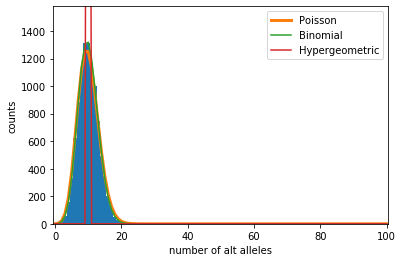

In [0]:
### 7

nsample = 10000  # the number of samples to draw.
alt_counts = []  # number of alternate alleles (i.e., 1's) for each draw

for i in range(nsample):
    offspring = generation(initial_population)
    alt_counts.append(offspring.sum())

hist = plt.hist(alt_counts, len(initial_population)+1, range=(0-0.5, len(initial_population)+0.5))
plt.xlabel("number of alt alleles")
plt.ylabel("counts")

# Here I just check that the initial population is still a list of length nInd
assert nInd == len(initial_population),"initial_population doesn't have the same length as nInd" 

x_range = range(nInd+1)                  # All the possible values
p=np.sum(initial_population)*1./nInd   # The initial frequency

# Compare this to some distributions
y_poisson = stats.poisson.pmf(x_range, nInd*p) * nsample
y_binom = stats.binom.pmf(x_range, nInd, p) * nsample
y_hypergeom = stats.hypergeom.pmf(x_range, nInd, np.sum(initial_population), nInd) * nsample

plt.plot(x_range, y_poisson, label="Poisson",lw=3)
plt.plot(x_range, y_binom, label="Binomial")
plt.plot(x_range, y_hypergeom, label="Hypergeometric")
plt.xlim(-0.5, nInd+0.5)
plt.ylim(0, 1.2*max(hist[0]))
plt.legend()

Now we are ready to evolve our population for 100 generations. Let's store the entire genotypes for each generation in a list.

In [0]:
### 8
nGen = 100  # Number of generations to simulate
history = [initial_population]  # A container list for our simulations. It will contain the population 
                                # state after generations 0 to nGen
for i in range(nGen):
    # evolve the population for one generation, and append the result to history.
    history.append(generation(history[i])) 
history = np.array(history)  # convert the list into an array for convenient manipulation later on

Now we want to look at the results. Let's compute the allele frequency at each generation and plot that as a function of time.

Text(0, 0.5, 'population frequency')

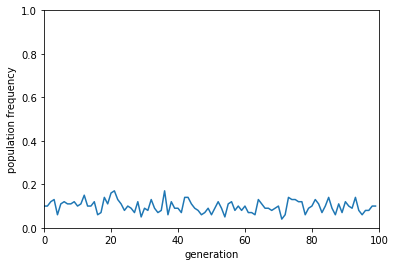

In [0]:
### 9
# Compute the allele frequency at each generation.
# freqs should be a list or array of frequencies, with one frequency per generation.
# history is a np array and has two methods that can help you here: sum, and mean. 
# Mean is probably the best bet here. 
freqs = [(history[i]).mean() for i in range(nGen)]
x_range = np.arange(100)
plt.plot(x_range, freqs)
plt.axis([0, 100, 0, 1]);#define the plotting range
plt.xlabel("generation")
plt.ylabel("population frequency")


Now we would like to experiment a bit with the tools that we have developed. Before we do this, we will organize them a bit better, using a Python "class" and object-oriented programming. We have defined above variables that describe a population (such as the population size nInd, and the ancestral frequency g0). We have also defined functions that apply to a population, such as "generation". A class is used to keep track of the relation between objects, variables, and functions. 

If you are not familiar with classes and are having issues, have a look at [this tutorial](http://en.wikibooks.org/wiki/A_Beginner's_Python_Tutorial/Classes#Creating_a_Class). 



    

In [0]:
### 10
class population:
    """
    Initialization call: 
    
    population(nInd,p0)
    requires a number of individuals nInd and an initial frequency p0
    
    Variables:
    nInd: The number of individuals
    p0: the initial allele frequency
    initial_population: an array of nInd alleles
    history: a list of genotypes for each generation 
    frequency_trajectory: an allele frequency trajectory; only defined if get_frequency_trajectory is run. 
    Methods:
    generation: returns the offspring from the current population, whish is also the last one in self.history
    evolve: evolves the population for a fixed number of generations, stores results to self.history
    get_frequency_trajectory: calculates the allele frequency history for the population
    plot_trajectory: plots the allele frequency history for the population
    
    """
    def __init__(self, nInd, p0): 
        """initialize the population. nInd is the number of individuals. p0 is the initial allele frequency.
        __init__ is a method that, when run, creates a "population" class and defines some of its variables. 
        Here we define this __init__ method but we don't run it, so there is no "population" created yet.  
        In the meantime, we'll refer to the eventual population object as "self".
        We'll eventually create a population by stating something like   
        pop = population(nInd,p0)
        This will call the __init__ function and pass a "population" object to it in lieu of self. 
        """
        self.nInd = nInd
        self.p0 = p0 
        # Initialize the population
        self.initial_population = np.zeros(self.nInd) 
        self.initial_population[0 : int(p0*self.nInd)] = 1
        np.random.shuffle(self.initial_population)
        # History is a container that records the genotype at each generation.
        # We'll update this list as we go along. For now it should just contains the initial population
        self.history = [self.initial_population] 

    def generation(self): 
        """class methods need "self" as an argument in they definition to know that they apply to a "population" 
        object. If we have a population "pop", we can write 
        pop.generation(), and python will know how to pass the population as the first argument. 
        
        Returns a descendant population according to Wright-Fisher dynamics with constant size, assuming that the
        parental population is the last generation of self.history. 
        """
        return np.random.choice(self.history[len(self.history) -1], self.nInd, replace = True) 

    def evolve(self, nGen): 
        """
        This is a method with one additional argument, the number of generations nGen. 
        To call this method on a population "pop", we'd call pop.evolve(nGen). 
        This function can be called many times on the same population. 
        pop.evolve(2)
        pop.evolve(3)
        would evolve the population for 5 generations. 
        For each step, we make a call to the function generation() and append the population to the "self.history"
        container. 
        """
        for _i in range(nGen):
            self.history.append(self.generation())
        self.get_frequency_trajectory() 
        # This computes self.frequency_trajectory, the list of population frequencies from the first generation 
                       # to the current one. the get_frequency_trajectory function is defined below. 

    def get_frequency_trajectory(self):
        """
        returns an array containing the allele frequency history for the population (i.e., the allele frequency at 
        generations 0,1,2,..., len(self.history))
        """
        history_array = np.array(self.history)
        self.frequency_trajectory = [np.sum(history_array[i]) for i in range(len(history_array))] 
        return self.frequency_trajectory

    def plot_trajectory(self,ax="auto"):
        """
        plots the allele frequency history for the population
        """
        
        plt.plot(self.get_frequency_trajectory())
        if ax=="auto":
            plt.axis([0, len(self.history), 0, 1]) 
        else:
            plt.axis(ax)
    

        

            
        
        

# Exploration
## Drift
We can now define multiple populations, and let them evolve from the same initial conditions.

In [0]:
### 11
nInd = 50
nGen = 30
nRuns = 30
p0 = 0.02
# Create a list of length nRuns containing initial populations 
# with initial frequency p0 and nInd individuals.
pops = [ population(nInd, p0) for i in range(nRuns)] 

Evolve each population for nGen generations. Because each population object has it's own internal storage for the history of the population, we don't have to worry about recording anything.

In [0]:
### 12
for pop in pops:
    pop.evolve(nGen)  

In [0]:
#toy example
c = population(nInd, p0)
c.evolve(nGen)
c.get_frequency_trajectory()

[1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Now plot each population trajectory, using the built-in method from the population class. 

Text(0, 0.5, 'population frequency of 1 allele')

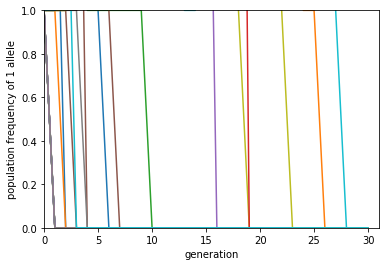

In [0]:
### 13
for pop in pops:
    pop.plot_trajectory()
plt.xlabel("generation")
plt.ylabel("population frequency of 1 allele") 

Now that we know it works, let's explore this a bit numerically. Try to get at least 1000 runs, it'll make graphs prettier down the road.  

Text(0, 0.5, 'population frequency')

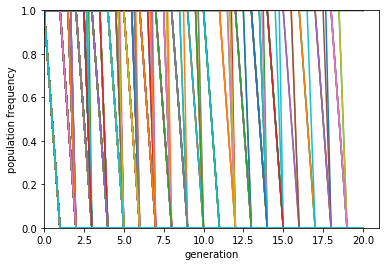

In [0]:
### 14
nInd = 50 
nGen = 20
nRuns = 1000
p0 = 0.02
pops = [population(nInd, p0) for i in range(nRuns)] 
for pop in pops:
    pop.evolve(nGen)
for pop in pops:
    pop.plot_trajectory()
plt.xlabel("generation")
plt.ylabel("population frequency") 


So there is a lot of randomness in there, but if you run it multiple times you should see that there is some regularity in how fast the allele frequencies depart from the initial values.  
To investigate this, calculate and plot the distribution of frequency at each generation. 

In [0]:
### 15
def frequencyAtGen(generation_number, populations, nBins=11):
    """calculates the allele frequency at generation genN for a list of populations pops. 
     Generates a histogram of the observed values"""
    counts_per_bin, bin_edge_positions = np.histogram([pop.get_frequency_trajectory()[generation_number] for pop in populations], bins=nBins, range=(0,1)) 
    
    bin_centers=np.array([(bin_edge_positions[i+1]+bin_edge_positions[i]) / 2 for i in range(len(counts_per_bin))]) 
    return bin_centers, counts_per_bin # Return the data from which we will generate the plot

Text(0, 0.5, 'Number of simulated populations ')

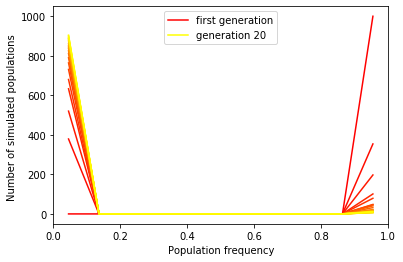

In [0]:
### 16
nBins = 11 # The number of frequency bins that we will use to partition the data.
for i in range(nGen+1):
    
    bin_centers, counts_per_bin = frequencyAtGen(i, pops); 
    if i==0:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen), label="first generation")  
                                                                        # cm.autumn(i*1./nGen) returns the 
                                                                        # color with which to plot the current line
    elif i==nGen:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen), label="generation %d"% (nGen,))
    else:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen))
plt.legend()
plt.xlabel("Population frequency")
plt.ylabel("Number of simulated populations ")


There are three important observations here:

    1-Frequencies tend to spread out over time 
    2-Over time, there are more and more populations at frequencies 0 and 1. (Why?)
    3-Apart from the 0 and 1 bins, the distribution becomes quite flat.

A few alternate ways of visualizing the data: first a density map

In [0]:
#toy example
bins = frequencyAtGen(i-1, pops, nBins=nBins)[0]
bins

array([0.04545455, 0.13636364, 0.22727273, 0.31818182, 0.40909091,
       0.5       , 0.59090909, 0.68181818, 0.77272727, 0.86363636,
       0.95454545])

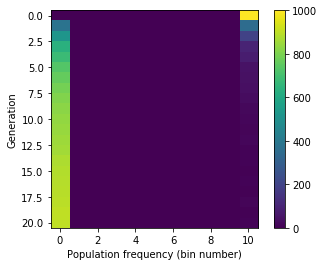

In [0]:
### 17
nBins = 11
sfs_by_generation = np.array([frequencyAtGen(i, pops, nBins=nBins)[1] for i in range(0, nGen+1)])
bins = frequencyAtGen(i, pops, nBins=nBins)[0]
plt.imshow(sfs_by_generation, aspect=nBins*1./nGen, interpolation='nearest')
plt.xlabel("Population frequency (bin number)")
plt.ylabel("Generation")
plt.colorbar()

Then a 3D histogram, unfortunately a bit slow to compute. 

In [0]:

len(sfs_by_generation.flatten())

231

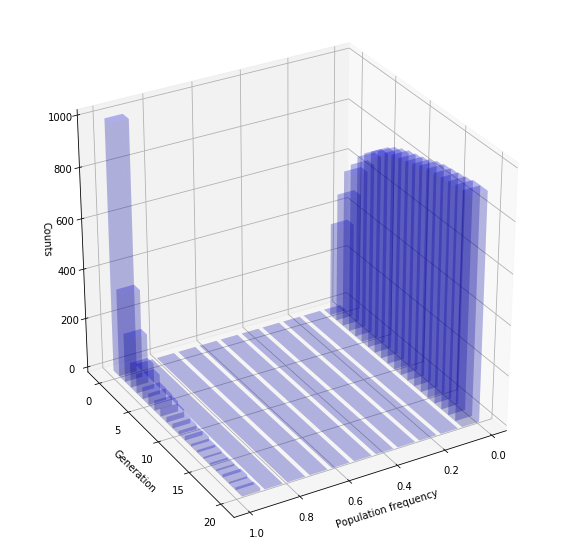

In [0]:
### 18
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', elev=90)
xedges = bins
yedges = np.arange(nGen+1)

xpos, ypos = np.meshgrid(xedges-.4/nBins, yedges-0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = 0 * ypos
dx = .8 / nBins
dy = 1
#sfs_by_generation = np.append(sfs_by_generation.flatten(), [0]*11)
dz = sfs_by_generation.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', edgecolor='none', alpha=0.15)

ax.view_init(elev=30., azim=60)
ax.set_xlabel("Population frequency")
ax.set_ylabel("Generation")
ax.set_zlabel("Counts")

plt.show()

Now let's dig into the effect of population size in a bit more detail.
Consider the change in the frequency of alleles between parent and offsprin. 

*Mathematical exercise (NOT optional)*:

* What is the distribution of the number of individuals carrying the derived allele after one generation, if the derived allele is at frequency $p$ in a parental population of size $N$? 
(Hint: we explored this numerically above!)
* What is the variance of this distribution? (Look it up if you don't know--wikipedia is useful for that kind of stuff). 
* What is the variance in the distribution in the derived allele *frequency* (rather than the allele counts)?

    
        

The Distribution is binomial where k is the number of individuals carrying the derived allele after one generation.
$${\displaystyle f(N, p)={\binom {N}{k}}p^{k}{(1-p)}^{N-k}.}$$
$$ Var_dist = Np(1-p) $$

$$Var_feq = p(1-p)/N$$


To study the effect of population size on the rate of change in allele frequencies, plot the distribution of allele frequencies after nGen generation. Start with nGen=1 generation. 



In [0]:

nInd = 10
nGen = 1
nRuns = 50
p0 = 0.5
numvar = []
for i in range(50):
    pops = [population(nInd, p0) for i in range(nRuns)] 
    [pop.evolve(nGen) for pop in pops]
    num_dived_allele= [pop.get_frequency_trajectory()[1] for pop in pops]
    numvar.append(np.var(num_dived_allele))
#this is expected veriance
num_var = sum(numvar)/len(numvar)
num_var

2.421352

In [0]:
#this is theoretical veriance
theroy_var = nInd*(1-p0)*p0 
theroy_var

2.5

In [0]:
num_feq_var = []
for i in range(1000):
    pops = [population(nInd, p0) for i in range(nRuns)] 
    [pop.evolve(nGen) for pop in pops]
    num_derived_allele = [pop.get_frequency_trajectory()[1] for pop in pops]
    freq = [ i/nInd  for i in num_derived_allele if i != 0]
    num_feq_var.append(np.var(freq))
numerical_feq_var = sum(num_feq_var)/len(num_feq_var)
numerical_feq_var

0.024123534019112432

In [0]:
theory_feq_var = p0*(1-p0)/nInd
theory_feq_var

0.025

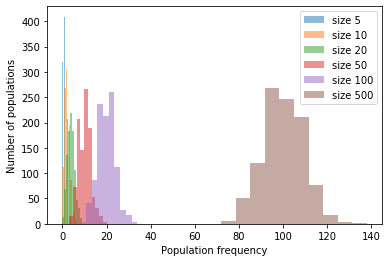

In [0]:
### 19
histograms = []
variances = []
p0 = 0.2
sizes = [5, 10, 20, 50, 100, 500]
nGen = 1
for nInd in sizes:
    pops = [population(nInd, p0) for i in range(1000)] 
    [pop.evolve(nGen) for pop in pops]
    sample = [pop.get_frequency_trajectory()[-1] for pop in pops]
    variances.append(np.var(sample))
    histograms.append(plt.hist(sample, alpha=0.5, label="size %d" % (nInd,) ))
plt.xlabel("Population frequency")
plt.ylabel("Number of populations")
plt.legend()

So how does population size affect the change in allele frequency after one generation? Can you give a specific function describing the relationship between variance and population size? 

You can get this relationship from the math exercise above, or just try to guess it from the data. If you want to try to guess, start by plotting the variances (stored in "variances") against the population sizes (stored in "sizes"). Then you can either try to plot different functinoal forms to see if they fit, or you can change the way you plot the data such that it looks like a straight line. If you do the latter, make sure you update the labels!

Here I'm giving you a bit more room to explore--there are multiple ways to get there.  

In [0]:
#toy example
variances = [0.7544710000000001,
 1.6287839999999998,
 3.130239,
 7.4027639999999995,
 16.226975,
 73.921964]
sizes = [5, 10, 20, 50, 100, 500]
y = 0
for i in range(6):
    print(sizes[i]/variances[i])

#sizes = variances*6.472783251944674

6.627159957109019
6.139549504415565
6.389288485639595
6.754233959099602
6.162578052902652
6.763889552501608


In [0]:
sizes = np.linspace(0, 500,1000)
variances = sizes/6.472783251944674

Text(0, 0.5, 'Variance')

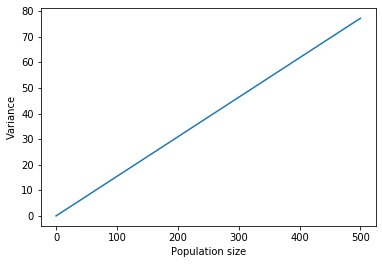

In [0]:

### 20
plt.plot(sizes, variances, label="simulation") #this is a starting point, but you can change this!
# Your theory.
plt.xlabel("Population size") 
plt.ylabel("Variance")  

For short times, the expected changes in allele frequencies, $Var\left[E[(x-x_0)^2)\right]$, are larger for smaller population, a crucial result of population genetics. 

The next question is: How does the rate of change in allele frequency depend on the initial allele frequency? We can plot the histograms of allele frequency as before:


$$ t = nGen $$
$$Var_t = p(1-p)(1- e^(t/N))$$

Text(0, 0.5, 'Number of populations')

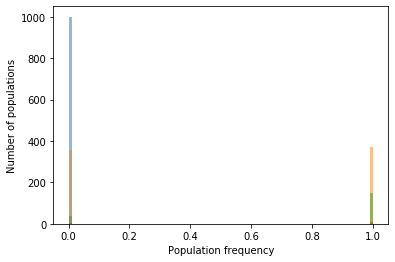

In [0]:
### 21
nInd = 30
histograms = []
variances = []
p0_list = np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, .6, .7, .8, 0.9, 0.95, 1]) 
nGen = 1 
for p0 in p0_list:
    pops = [population(nInd, p0) for i in range(1000)] 
    [pop.evolve(nGen) for pop in pops]
    sample = [pop.get_frequency_trajectory()[-1] for pop in pops]
    variances.append(np.var(sample))
    histograms.append(plt.hist(sample, 100, alpha=0.5, range=(0,1)))
plt.xlabel("Population frequency")
plt.ylabel("Number of populations")

Find the relationship between initial frequency and variance. You can deduce it from the math exercise above, look it up on wikipedia, but you can also just try to guess it from the simulations. 

Tips for guessing: 

First, make the plot of variance vs frequency below

Then consider how much variance there is for p0=0 and p0=1.  

Can you come up with a simple function that has these values? Hint: it's a very simple function!




sizes = variances*6.472783251944674


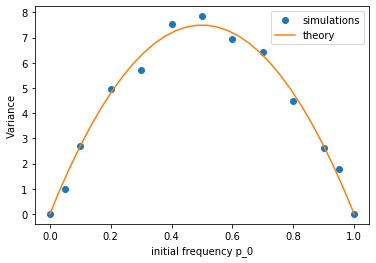

In [0]:
### 22
p0_list2 = np.linspace(0, 1, 30)
N = len(p0_list2)
variances2 = np.array([ N*p*(1-p) for p in p0_list2])
plt.plot(np.array(p0_list), variances, 'o', label="simulations")
plt.plot(np.array(p0_list2), variances2, '-', label="theory")  # Your theory.  
plt.ylabel("Variance")
plt.xlabel(r"initial frequency p_0")
plt.legend()

Can you explain why this function is symmetrical around $p_0=0.5$?

## Mutation
New mutations enter the population in a single individual, and therefore begin their journey at frequency $\frac{1}{N}$. Next, we'll numerically estimate the probability that such a new mutation will eventually fix (i.e., the probability that the mutation reaches frequency 1) in the population, if no subsequent mutations occur. 



In [0]:
### 23

nInd = 10
nGen = 100
nRuns = 2000
# Enter the initial allele frequency for new mutations
p0 = 1/nInd
pops = [population(nInd, p0) for i in range(nRuns)] 
[pop.evolve(nGen) for pop in pops]; 

We can plot the number of populations at each frequency, as we did above.

Text(0, 0.5, 'Number of simulations')

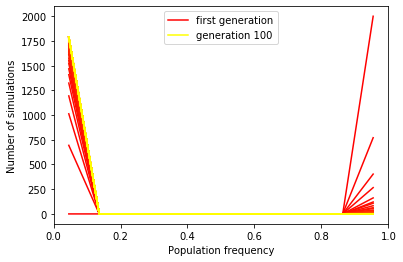

In [0]:
### 24
nBins = nInd + 1  # We want to have bins for 0,1,2,..., N copies of the allele. 
proportion_fixed = []  # fixation rate
for i in range(nGen+1):
    x,y = frequencyAtGen(i, pops, nBins);     
    if i==0:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen), label="first generation")  # cm.autumn(i*1./nGen) returns the 
                                                                            #color with which to plot the current line
    elif i==nGen:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen), label="generation %d"% (nGen,) )
    else:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen))
    
    # We'll consider a population "fixed" if it is in the highest-frequency bin. It's
    # an approximation, but not a bad one if the number of bins is comparable to the 
    # population size.
    proportion_fixed.append((i, y[-1]*1./nRuns))
    
plt.legend()    
plt.xlabel("Population frequency")
plt.ylabel("Number of simulations")

In [0]:
nBins = nInd + 1  
pro_fixed = []  
for i in range(nGen+1):
    y = [pop.get_frequency_trajectory()[nGen] for pop in pops]  
    pro_fixed.append(sum(y)/nRuns)

In [0]:
num_fixed = sum([i/nInd for i in pro_fixed])/nGen
num_fixed

0.10605000000000026

Here you should find that most mutations fix at zero frequency--only a small proportion survives. 

*What is the probability that a new mutation fixes in the population?*--I'd like you to solve this problem both mathematically and numerically.  

The mathematical part requires almost no calculation or mathematical knowledge, once you think about it in the right way. You can include your mathematical solution in the box below. 

$$prob = p0 $$

In [0]:
theory_prob = 1/(nInd)
theory_prob

0.1

For the computational part, note that we already computed the proportion of fixed alleles vs time in the "proportion_fixed" variable. So if we simulate long enough, we'll find the proportion of mutations that eventually fix.  
Make sure that the numerical value agrees with the mathematical expectation!

Text(0, 0.5, 'Fixation probability')

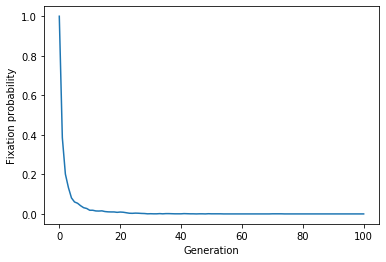

In [0]:
### 25
proportion_fixed = np.array(proportion_fixed)
plt.plot(proportion_fixed[:,0], proportion_fixed[:,1])
plt.xlabel("Generation")
plt.ylabel("Fixation probability")

# Summary

Some important things that we've seen in this notebook:
* The Wright-Fisher model. Despite its simplicity, it is the basic building block of a large fraction of population genetics.
* In finite populations, sampling fluctuations are an important driver of allele frequency change.
* These sampling fluctuations cause larger frequency changes in smaller populations.
* These fluctuations mean that alleles eventually fix one way or another -- We need new mutations to maintain diversity within a population.
* For neutral alleles, the probability of new mutations fixing in the population is inversely proportional to the population size

# Something to think about. 

We'll get to selection, recombination, and linkage in the next exercises. In the meantime, you can think about the following:
 
* How much time will it take for a typical new mutation to reach fixation for different population sizes? 
* If you add a constant influx of new mutations, how will the distribution of allele frequency look like at any given point in time?





Copyright: Simon Gravel. Do not share of distribute this file without the written consent of the author. 